# PCL on 1D equation - parameter inverse problem

We want to solve the inverse parameter identification problem: find $c$ such that 

$$ -\nabla \cdot (c \nabla u) = f(x), \quad x \in (0,1), \\
   u(0)= u(1)=0 $$ 
   
with $ c = 1$ and $f(x)=2, $ given the unique measurement

$$ u(0.5) = 0.25 .$$

The analytical solution is $$u(x)=x(1-x).$$

**Direct Problem**

Given $c \in \mathbb{R},$ compute $u(x),$ $0\le x \le 1.$

**Inverse problem**

Given $u(x_i),$ $i \in \mathcal{I}_{\mathrm{obs}},$ find $c \in \mathbb{R}.$

We use a [physics constrained learning](https://www.sciencedirect.com/science/article/abs/pii/S0021999121008330) (PCL) approach, based on automatic differentiation and backpropagation, to compute the gradient of the loss function with respect to the inversion parameter. PCL differs from PINN (see later Examples) in that it is:

- more robust to noise,
- requires fewer iterations for stiff problems,,
- no tuning of regularization hyperparameters is needed,
- can deal with weak solutions (FEM),
- exhibits mesh-independent convergence.

We will see that this is fine for constant-parameter inversion, but more complicated for function-valued inverse design, where PINN is probably better since the physics/equation is included in the loss function in the latter. 

In [1]:
# Setup device agnostic code
#device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "mps" if torch.backends.mps.is_available() else "cpu"
#print(f"Using device: {device}")

## Method

In the code, we define and use the follwing:

- an initial guess $c_0 = 10.$
- a centered finite difference discretization of the (P)DE
- a built-in linear algebra solver for the discretized equation $$ Au = f$$
- a quasi-Newton (L)BFGS optimizer

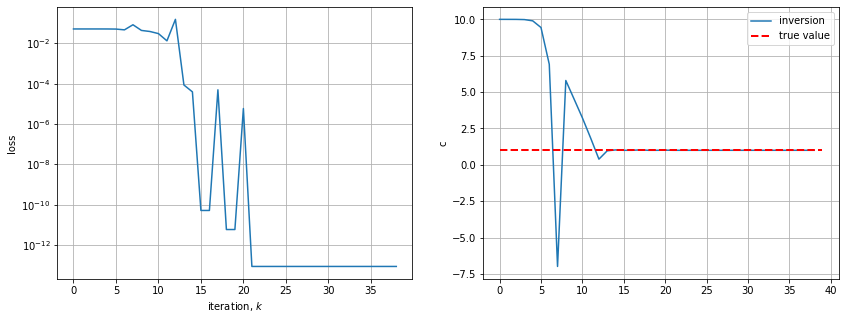

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

n = 100
h = 1/n

# set up the discretization
c = torch.tensor(10., requires_grad=True)
I1 = torch.ones(n-1)
I2 = torch.ones(n-2)
f = 2.0*torch.ones(n-1)

def fwd_model(c):
    A = c*(torch.diag(2/h**2 * I1,0) + torch.diag(-1/h**2 * I2,1) + torch.diag(-1/h**2 * I2,-1))
    # solve the linear system
    u = torch.linalg.solve(A, f)
    return u

optimizer = optim.LBFGS([c],
                        history_size=10,
                        max_iter=4,
                        line_search_fn="strong_wolfe")

tol_it_max = 20
target = 0.25
it_history = []
c_history  = []
# optimization loop
for n_iter in range(tol_it_max):
    def closure():
        optimizer.zero_grad()
        c_history.append(c.item()) 
        output = fwd_model(c)
        loss = (output[50] - target)**2 # loss_fn(output, target)
        loss.backward()
        it_history.append(loss.item()) 
        return loss
    optimizer.step(closure)

# plot iteration history
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.semilogy(range(len(it_history)), it_history) #, label='L-BFGS')
plt.xlabel('iteration, $k$')
plt.ylabel('loss')
plt.grid()
#plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(c_history)), c_history, label='inversion')
plt.hlines(y=1.0, xmin=0, xmax=39, colors='red', linestyles='--', lw=2, label='true value')
plt.legend()
plt.ylabel('c')
plt.grid()
plt.show()

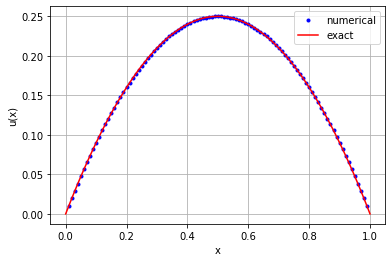

In [3]:
import numpy as np
u = fwd_model(c)
x = np.arange(0,1+h,h)
sol = x*(1.-x)
plt.plot(x[1:-1], u.detach().numpy(), 'b.', x, sol,'r' )
plt.legend(['numerical', 'exact'])
plt.xlabel('x'), plt.ylabel('u(x)')
plt.grid()
plt.show()

## Conclusions

1. We have solved the 1D parameter identification inverse problem with precision and efficiency.
2. We require only 20 iterations of LBFGS to converge in the loss and in the parameter value.
3. The learning is constrained by the physics in that the forward model (DE) is used to compute the output.